In [1]:
from scipy.stats import rv_discrete
import numpy as np

from numba import njit

"Compute the τ-th quantile of v(X) when X ∼ ϕ and v = sort(v)."
@njit
def quantile(τ, v, ϕ):
    for (i, v_value) in enumerate(v):
        p = sum(ϕ[:i+1])  # sum all ϕ[j] s.t. v[j] ≤ v_value
        if p >= τ:         # exit and return v_value if prob ≥ τ
            return v_value

"For each i, compute the τ-th quantile of v(Y) when Y ∼ P(i, ⋅)"
def R(τ, v, P):
    return np.array([quantile(τ, v, P[i, :]) for i in range(len(v))])

def quantile_test(τ):
    ϕ = [0.1, 0.2, 0.7]
    v = [10, 20, 30]

    #d = DiscreteNonParametric(v, ϕ)
    d = rv_discrete(values=(v, ϕ))
    return quantile(τ, v, ϕ), d.ppf(τ)
    



In [2]:
"""
Job search with Markov wage draws and quantile preferences.

"""
from quantecon import tauchen, MarkovChain
import numpy as np
from quantile_function import *

"Creates an instance of the job search model."
def create_markov_js_model(
        n=100,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0,       # unemployment compensation
        τ=0.5        # quantile parameter
    ):
    mc = tauchen(n, ρ, ν)
    w_vals, P = np.exp(mc.state_values), mc.P
    return (n, w_vals, P, β, c, τ)

"""
The policy operator 

    (T_σ v)(w) = σ(w) (w / (1-β)) + (1 - σ(w))(c + β (R_τ v)(w))

"""
def T_σ(v, σ, model):
    n, w_vals, P, β, c, τ = model
    h = [x + c for x in β * R(τ, v, P)]
    e = w_vals / (1 - β)
    return σ * e + (1 - σ) * h

" Get a v-greedy policy."
def get_greedy(v, model):
    n, w_vals, P, β, c, τ = model
    σ = w_vals / (1 - β) >= c + β * R(τ, v, P)
    return σ


"Optimistic policy iteration routine."
def optimistic_policy_iteration(model, tolerance=1e-5, m=100):
    n, w_vals, P, β, c, τ = model
    v = np.ones(n)
    error = tolerance + 1
    while error > tolerance:
        last_v = v
        σ = get_greedy(v, model)
        for i in range(m):
            v = T_σ(v, σ, model)
        
        error = max(np.abs(v - last_v))
        print(f"OPI current error = {error}")
    
    return v, get_greedy(v, model)


# == Plots == #

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 14})

def plot_main(tau_vals=(0.1, 0.25, 0.5, 0.6, 0.7, 0.8), 
                     savefig=False, 
                     figname="../figures/quantile_js.pdf"):

    w_star_vals = np.zeros(len(tau_vals))

    for (τ_idx, τ) in enumerate(tau_vals):
        model = create_markov_js_model(τ=τ)
        n, w_vals, P, β, c, τ = model
        v_star, σ_star = optimistic_policy_iteration(model)
        for i in range(n):
            if σ_star[i] > 0:
                w_star_vals[τ_idx] = w_vals[i]
                break

    model = create_markov_js_model()
    n, w_vals, P, β, c, τ = model
    mc = MarkovChain(P)
    s = mc.stationary_distributions[0]

    fig, ax = plt.subplots()
    ax.plot(tau_vals, w_star_vals, "k--", lw=2, alpha=0.7, label="reservation wage")
    ax.barh(w_vals, 32 * s, alpha=0.05, align="center")
    ax.legend(frameon=False, loc="upper center")
    ax.set_xlabel("quantile")
    ax.set_ylabel("wages")

    if savefig:
        fig.savefig(figname)


OPI current error = 197.04958104222322
OPI current error = 32.41999066047552
OPI current error = 35.62127408582426
OPI current error = 34.1446640510786
OPI current error = 31.357190366860497
OPI current error = 27.984260985215176
OPI current error = 23.254898512652094
OPI current error = 16.591569430034006
OPI current error = 7.09109988950496
OPI current error = 3.102226038720346e-06
OPI current error = 197.04958104222322
OPI current error = 32.41999066047552
OPI current error = 29.678936943622382


OPI current error = 29.093921296620483
OPI current error = 27.974814794615806
OPI current error = 26.72531111677077
OPI current error = 25.39554124988487
OPI current error = 23.255076254919008
OPI current error = 20.92822560847147
OPI current error = 18.39891195068428
OPI current error = 14.680917085664738
OPI current error = 10.525484762612273
OPI current error = 5.881149036250456
OPI current error = 9.59630597208161e-10
OPI current error = 197.04958104222322
OPI current error = 36.59694294236868
OPI current error = 0.676518038229375
OPI current error = 0.08971952178475817
OPI current error = 0.011898563134202789
OPI current error = 0.001577982158643465
OPI current error = 0.00020927129308034864
OPI current error = 2.7753465943192168e-05
OPI current error = 3.6806523482368902e-06
OPI current error = 197.04958104222322
OPI current error = 51.40389833249008


OPI current error = 0.0
OPI current error = 197.04958104222322
OPI current error = 82.51356008425164
OPI current error = 0.0
OPI current error = 197.04958104222322
OPI current error = 133.14095588610522
OPI current error = 0.0


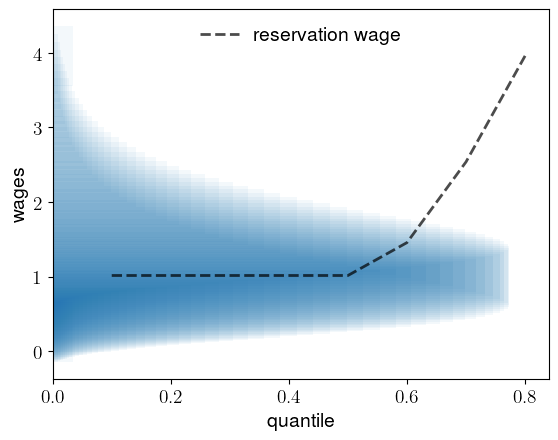

In [3]:
plot_main(savefig=True)